# Concolutional Neural Network

## Importation librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import time

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

import random

## Importation et affichage données

health: -1.0
[ 0.50205548  0.54216265  0.72238348  1.4288852   2.1365158   2.281149
  1.9362737   1.46889     1.0088451   0.38028224 -0.29677967 -0.51392868
 -0.25564469 -0.10720254 -0.28782655 -0.41800901 -0.31916313 -0.2603787
 -0.35035721 -0.50548599 -0.71088709 -0.82391982 -0.89970154 -1.1539497
 -1.2298306  -1.044091   -1.2020312  -1.3921949  -1.1301083  -1.1798666
 -1.6492718  -1.7265754  -1.6083704  -1.6628022  -1.6506724  -1.6973094
 -1.8386968  -1.8025962  -1.7805361  -1.8251665  -1.6447633  -1.4238097
 -1.3921949  -1.3604156  -1.2001781  -0.91863234 -0.68591581 -0.66794346
 -0.51272154 -0.10169069  0.06395426  0.08261431  0.23760718  0.17479318
  0.12320539  0.5033942   0.6838702   0.47499476  0.53279711  0.72354995
  0.6644198   0.64793559  0.75705403  0.7320716   0.62021499  0.60629677
  0.67795016  0.68908363  0.59880728  0.54264656  0.58180737  0.63063068
  0.6644198   0.6863178   0.65738251  0.65088944  0.72173837  0.73970645
  0.69148052  0.69522947  0.7501145   0.85384

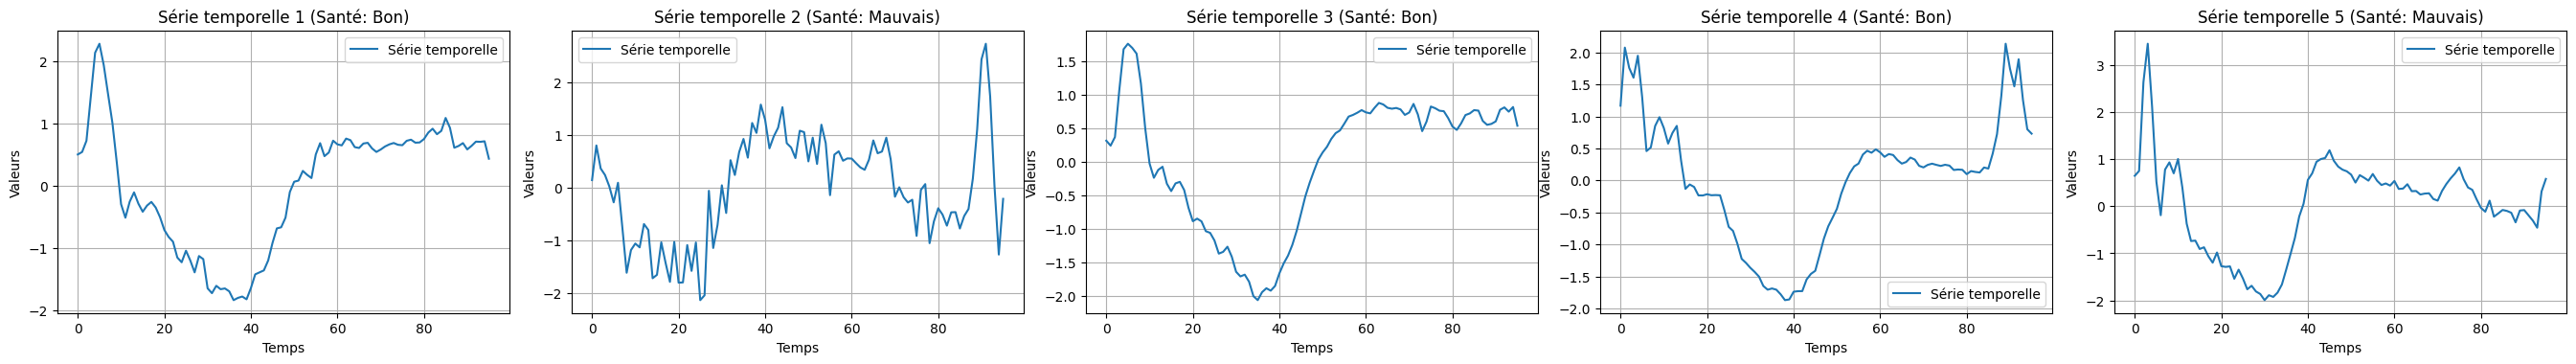

In [2]:
train_data = np.loadtxt('data/ECG200_TRAIN.tsv', delimiter='\t')
test_data = np.loadtxt('data/ECG200_TEST.tsv', delimiter='\t')

# Afficher la première série temporelle
print("health:", train_data[0,0])
print(train_data[0,1:])

# Afficher les dimensions des données
print("Dimensions des données d'entrainnement:", train_data.shape)
print("Dimensions des données de test:", test_data.shape)

# Afficher les 5 premières séries temporelles
nb_series_a_afficher = 5
plt.figure(figsize=(27, 7))
for i in range(nb_series_a_afficher):
    # Extraire la série temporelle et son état de santé correspondant
    serie_temporelle = train_data[i, 1:]
    etat_sante = train_data[i, 0]
    
    # Créer une plage de temps pour l'axe x
    plage_temps = range(len(serie_temporelle))
    
    # Placer la série temporelle dans le sous-graphique correspondant
    plt.subplot(2, nb_series_a_afficher, i+1)
    plt.plot(plage_temps, serie_temporelle, label='Série temporelle')
    plt.xlabel('Temps')
    plt.ylabel('Valeurs')
    plt.title(f'Série temporelle {i+1} (Santé: {"Bon" if etat_sante == -1 else "Mauvais"})')
    plt.legend()
    plt.grid(True)

# Ajuster automatiquement les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()



## Traitement données

In [3]:
# Normaliser les classe
train_data[train_data[:, 0] == -1, 0] = 0
test_data[test_data[:, 0] == -1, 0] = 0

# Séparation des données d'entrainnements et de tests
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

# Concaténer les données d'entraînement et de test pour trouver les valeurs maximales et minimales globales
all_data = np.concatenate((X_train, X_test), axis=0)
# Trouver les valeurs maximales et minimales globales
global_max = np.max(all_data)
global_min = np.min(all_data)
# Normaliser les séries temporelles entre 0 et 1 en utilisant les valeurs maximales et minimales globales
X_train_normalized = (X_train - global_min) / (global_max - global_min)
X_test_normalized = (X_test - global_min) / (global_max - global_min)

"""# Normaliser les série temporelle entre 0 et 1
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)"""

# Convertir les étiquettes en encodage one-hot
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

"""
print(X_train_normalized.shape)
print(X_train_normalized)
print(y_train_encoded.shape)
print(y_train_encoded)
"""


'\nprint(X_train_normalized.shape)\nprint(X_train_normalized)\nprint(y_train_encoded.shape)\nprint(y_train_encoded)\n'

## Choix des Hyperparamètres

❒ Les hyperparamètres des layers : kernel size, dropout, méthode d’activation des layers cachés, méthode d’activation du layer final, …

❒ Les hyperparamètres de compilation du modèle: optimizer, loss, learning rate …

❒ Les hyperparamètres d’exécution du modèle : batch size, nombre d’epochs, …

In [4]:
# HyperParameter des layers :
# specify filter numbers
filters = 1
# specify filter size
kernel_size = 3
# specify stride size
stride = 1
# 
padding = 'same'
# specify activation
activation = 'relu'
# specify pooling size
pool_size = 3
# taux de déconnexion
dropout_rate = 0.3
# number of classe
nb_classes = 2

# HyperParameter de compilation : 
# choose learning rate
learning_rate = 0.001
# choose the optimization algorithm by specifying the learning rate
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# choose the cost function: categorical cross entropy
cost_function = tf.keras.losses.categorical_crossentropy

## HyperParameter d’exécution : 
# choose batch size
mini_batch_size = 16
# choose number of epochs
nb_epochs = 600
# specify the percentage for validation
percentage_of_train_as_validation = 0.2

## Création du modèle

In [5]:
# input
input_shape = (96, 1)
input_layer = Input(input_shape)

# block
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(input_layer)
relu_layer_1_1 = Activation('relu')(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding='same')(relu_layer_1_1)
relu_layer_1_2 = Activation('relu')(conv_layer_1_2)
pooling_layer_1 = MaxPooling1D(pool_size = pool_size, padding='same')(relu_layer_1_2)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(relu_layer_1_1)

# output
flattened_layer = Flatten()(pooling_layer_1)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes, activation='softmax')(dropout_flattened)

model = Model(inputs=input_layer, outputs=output_layer)

## Compilation du modèle

In [6]:
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 96, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (296.00 B)

 Trainable params: 74 (296.00 B)

 Non-trainable params: 0 (0.00 B)

## Entrainnement du modèle

In [7]:
# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)
#model_checkpoint = model.save('my_model.keras')

# start training
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])


## Résultats du meilleur modèle

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.4215  
Test Loss: 0.42445752024650574
Test Accuracy: 0.7900000214576721


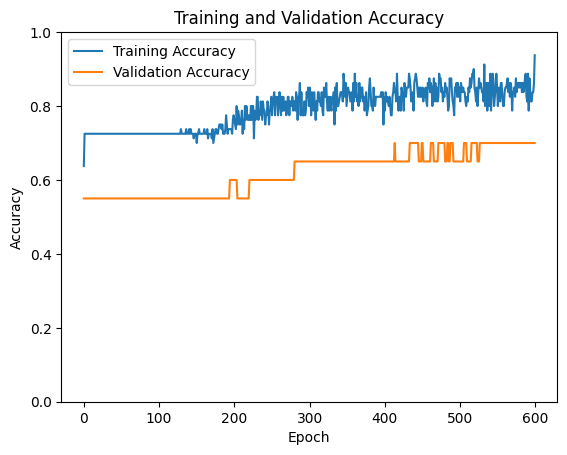

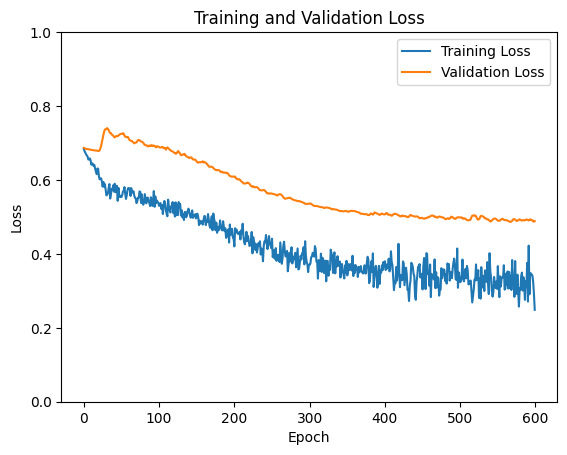

In [8]:

# Charge le meilleur modèle
best_model = tf.keras.models.load_model('best_model_CNN.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()

## Matrice de confusion

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


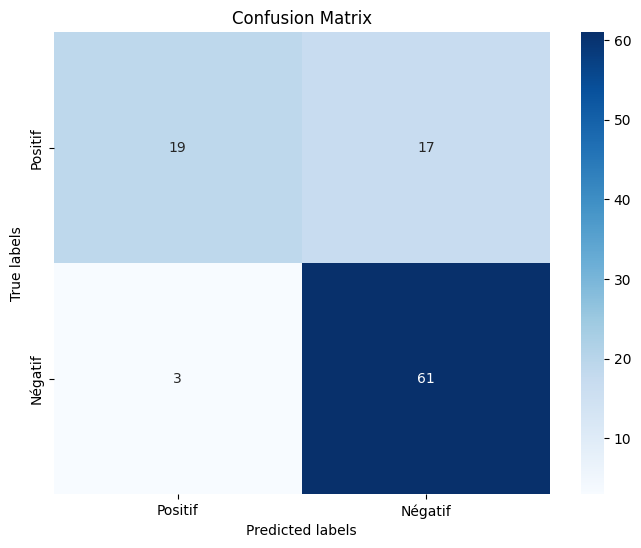

In [9]:
class_names = ['Positif', 'Négatif']

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)    

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Recherche des hyperparamètre
par recherche par grille et recherche aléatoire


## Meilleur modèle


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8784 - loss: 0.3310  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8240 - loss: 0.3946 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Nombre total de paramètres : 272
Temps d'entraînement : 0.0 minutes et 26.369850873947144 secondes.
Test Loss : 0.40459099411964417
Test Accuracy : 0.8100000023841858
AUC-ROC :  0.8871527777777777
Train Loss : 0.3464421331882477
Train Accuracy : 0.8600000143051147


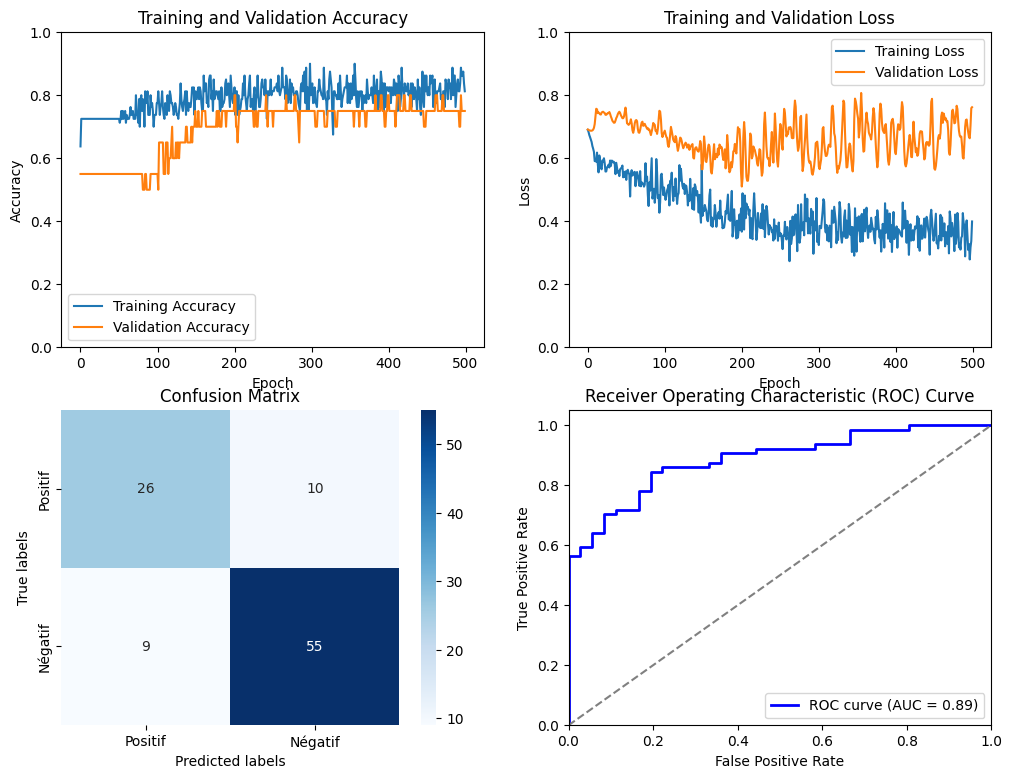

In [41]:
"""
Best hyperparameters: [(5, 2, 2, 'softmax', 2, 0.27, 0.007, 32), (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32), 
                        (5, 2, 2, 'softmax', 2, 0.27, 0.006, 32), (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32)]
Best hyperparameters 2: [(5, 2, 2, 'softmax', 2, 0.27, 0.007, 32), (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32), 
                        (5, 2, 2, 'softmax', 2, 0.25, 0.007, 32), (5, 2, 2, 'softmax', 2, 0.27, 0.006, 32), 
                        (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32), (5, 2, 2, 'softmax', 2, 0.23, 0.008, 32), 
                        (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32), (5, 2, 2, 'softmax', 2, 0.25, 0.007, 32), 
                        (5, 2, 2, 'softmax', 2, 0.25, 0.007, 32), (5, 2, 2, 'softmax', 2, 0.23, 0.007, 32), 
                        (5, 2, 2, 'softmax', 2, 0.25, 0.008, 32), (5, 2, 2, 'softmax', 2, 0.25, 0.006, 32)]
Meilleure perte : 0.32279372215270996
Meilleure précision : 0.8700000047683716
Temps d'entraînement des hyperparamètre : 18.0 minutes et 54.2466197013855 secondes.
"""
"""2*2
Meilleurs hyperparamètres : (5, 3, 1, 1, 0.3, 0.001, 32)
Meilleure perte : 0.4213484227657318
Meilleure précision : 0.8700000047683716
Temps d'entraînement des hyperparamètre : 49.0 minutes et 44.062196493148804 secondes.

(filters, kernel_size, stride, pool_size, dropout_rate, learning_rate, mini_batch_size)
"""

filters = 5
kernel_size = 2
stride = 2
padding = 'same'
use_bias = False
hidden_activation = 'relu'
final_activation = 'softmax' #'sigmoid' 
pool_size = 2
dropout_rate = 0.25
nb_classes = 2
learning_rate = 0.006
optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
cost_function = tf.keras.losses.categorical_crossentropy
mini_batch_size = 32
nb_epochs = 500
percentage_of_train_as_validation = 0.2

# input
input_shape = (96, 1)
input_layer = Input(input_shape)
conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
conv_layer_1_3 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_2)
relu_layer_1_3 = Activation(hidden_activation)(conv_layer_1_3)
pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_3)
dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
conv_layer_2_3 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_2)
relu_layer_2_3 = Activation(hidden_activation)(conv_layer_2_3)
pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_3)
flattened_layer = Flatten()(pooling_layer_2)
dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)

# build and compil model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

# specify the model checkpoint (to save the best model for each epoch)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

# start training
start_time = time.time()
history = model.fit(X_train_normalized, y_train_encoded, 
                    batch_size=mini_batch_size, 
                    epochs=nb_epochs,
                    validation_split=percentage_of_train_as_validation,
                    verbose=False,
                    callbacks=[model_checkpoint])
end_time = time.time()

# Eveluate best model
best_model = tf.keras.models.load_model('best_model_CNN.keras')
train_loss, train_accuracy = best_model.evaluate(X_train_normalized, y_train_encoded)
test_loss, test_accuracy = best_model.evaluate(X_test_normalized, y_test_encoded)
y_pred = best_model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
fpr, tpr, thresholds = roc_curve(y_test_encoded[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# result
class_names = ['Positif', 'Négatif']
tf.keras.utils.plot_model(best_model, show_shapes=True)
training_time_seconds = end_time - start_time
print(f"Nombre total de paramètres : {best_model.count_params()}")
print(f"Temps d'entraînement : {training_time_seconds // 60} minutes et {training_time_seconds % 60} secondes.")
print(f"Test Loss : {test_loss}")
print(f"Test Accuracy : {test_accuracy}")
print(f"AUC-ROC : ", roc_auc)
print(f"Train Loss : {train_loss}")
print(f"Train Accuracy : {train_accuracy}")

# Plot 
plt.figure(figsize=(12, 9))# mettre plus d'espace
# Training and Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0, 1)
# Training and Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(0, 1)
# Confusion Matrix
plt.subplot(2, 2, 3)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# ROC Curve
plt.subplot(2, 2, 4)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')


In [43]:
import numpy as np
from sklearn.model_selection import KFold

# Nombre de plis pour la validation croisée
k = 20

# Créer l'objet KFold
kf = KFold(n_splits=k)

# Liste pour stocker les scores de validation
validation_scores = []
loss_scores = []

# Boucle sur les plis de la validation croisée
for train_index, val_index in kf.split(X_train_normalized):
    # Séparer les données en ensembles d'entraînement et de validation
    X_train_fold, X_val_fold = X_train_normalized[train_index], X_train_normalized[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

        
    filters = 5
    kernel_size = 2
    stride = 2
    padding = 'same'
    use_bias = False
    hidden_activation = 'relu'
    final_activation = 'softmax' #'sigmoid' 
    pool_size = 2
    dropout_rate = 0.25
    nb_classes = 2
    learning_rate = 0.006
    optimizer_algo = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    cost_function = tf.keras.losses.categorical_crossentropy
    mini_batch_size = 32
    nb_epochs = 500
    percentage_of_train_as_validation = 0.2

    # input
    input_shape = (96, 1)
    input_layer = Input(input_shape)
    conv_layer_1_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(input_layer)
    relu_layer_1_1 = Activation(hidden_activation)(conv_layer_1_1)
    conv_layer_1_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_1)
    relu_layer_1_2 = Activation(hidden_activation)(conv_layer_1_2)
    conv_layer_1_3 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_1_2)
    relu_layer_1_3 = Activation(hidden_activation)(conv_layer_1_3)
    pooling_layer_1 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_1_3)
    dropout_layer_1_1 = Dropout(rate=dropout_rate)(pooling_layer_1)
    conv_layer_2_1 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(dropout_layer_1_1)
    relu_layer_2_1 = Activation(hidden_activation)(conv_layer_2_1)
    conv_layer_2_2 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_1)
    relu_layer_2_2 = Activation(hidden_activation)(conv_layer_2_2)
    conv_layer_2_3 = Conv1D(filters=filters,kernel_size=kernel_size,strides=stride,padding=padding,use_bias=use_bias)(relu_layer_2_2)
    relu_layer_2_3 = Activation(hidden_activation)(conv_layer_2_3)
    pooling_layer_2 = MaxPooling1D(pool_size=pool_size, padding=padding)(relu_layer_2_3)
    flattened_layer = Flatten()(pooling_layer_2)
    dropout_flattened = Dropout(rate=dropout_rate)(flattened_layer)
    output_layer = Dense(units=nb_classes,activation=final_activation)(dropout_flattened)

    # build and compil model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])

    # specify the model checkpoint (to save the best model for each epoch)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_CNN.keras', monitor='val_loss', save_best_only=True)

    
    # Entraîner le modèle sur les données d'entraînement du pli actuel
    history = model.fit(X_train_fold, y_train_fold, 
                        batch_size=mini_batch_size, 
                        epochs=nb_epochs,
                        validation_data=(X_val_fold, y_val_fold),
                        verbose=False,
                        callbacks=[model_checkpoint])
    
    # Évaluer le modèle sur les données de validation du pli actuel
    best_model = tf.keras.models.load_model('best_model_CNN.keras')
    train_loss, train_accuracy = best_model.evaluate(X_train_normalized, y_train_encoded)
    val_loss, val_accuracy =  best_model.evaluate(X_test_normalized, y_test_encoded)
    
    # Stocker le score de validation
    if(train_accuracy > 0.75):
        validation_scores.append(val_accuracy)
        loss_scores.append(val_loss)

# Calculer la moyenne des scores de validation
print(np.mean(validation_scores))
print(np.mean(loss_scores))



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.1683  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7441 - loss: 0.5965 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.2079  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9082 - loss: 0.2617 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.2640  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7815 - loss: 0.4782 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9097 - loss: 0.1888  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - loss: 0.3039 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7097 - loss: 0.5996  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7060 - loss: 0.5996 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.3875  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.4396 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8515 - loss: 0.3227  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 -